# Engage 2: Value from Clicks to Conversions

### Goal:
This notebook analyzes user engagement data to predict purchase values from click-through data. The goal is to build a robust regression model that can accurately predict the purchase value based on various user interaction features.

### Content:
1. *Data Loading and Setup*
2. *Exploratory Data Analysis (EDA)*
3. *Data Preprocessing and Feature Engineering*
4. *Model Development and Hyperparameter Tuning*
5. *Model Comparison and Performance Analysis*
6. *Final Submission*

# 1. Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

#Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
import xgboost as xgb

# 2. Loading Data

In [2]:
# To check available data files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv
/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv


In [3]:
# Loading datasets
file_path_train = '/kaggle/input/engage-2-value-from-clicks-to-conversions/train_data.csv'
file_path_test = '/kaggle/input/engage-2-value-from-clicks-to-conversions/test_data.csv'
file_path_submission = '/kaggle/input/engage-2-value-from-clicks-to-conversions/sample_submission.csv'

# Assigning Variables
train_original = pd.read_csv(file_path_train)
test_original = pd.read_csv(file_path_test)
submission_format = pd.read_csv(file_path_submission)

# Working copies
train = train_original.copy()
test = test_original.copy()


print(f"Data loaded successfully!\n")
print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

Data loaded successfully!

Training data shape: (116023, 52)
Test data shape: (29006, 51)


# 3. Exploratory Data Analysis (EDA)

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format) #for better readability 

## 3.1 Dataset Overview and Basic Statistics

### Feature Details

**1. User Behavior & Session Metrics**
  
* *totalHits, pageViews, totals.bounces, new_visits, totals.visits:*

  Indicators of user engagement and session activity.

* *sessionNumber, sessionStart:*

  Information related to session sequence and timing.

**2. Device & Technical Attributes**
* *deviceType, os, browser, screenSize, device.browserSize, device.language:*

  Details about the user's device and browsing environment.

* *browserMajor, device.:*

    Encompasses a variety of device-level descriptors such as model, version, and screen specifications.

* *gclIdPresent:*

  Signals the presence of a Google Click ID used in ad tracking.

**3. Traffic & Marketing Source**
* *userChannel, trafficSource, trafficSource.medium, trafficSource.keyword, trafficSource.campaign:*

  Insights into how users arrived at the platform.

* *trafficSource.adwordsClickInfo.:*

   Contains attributes from advertising sources, including ad network type and slot.

* *trafficSource.adContent, trafficSource.referralPath, trafficSource.isTrueDirect:*

  Provide further attribution details.

**4. Geographical Context**
* *geoNetwork.city, locationCountry, geoNetwork.continent, geoNetwork.subContinent, geoNetwork.metro, geoNetwork.region:*

  Geographic identifiers to help understand regional behavior trends.
  
* *geoCluster, locationZone:*

    Groupings based on geographic or behavioral patterns.

**5. Identifiers**
* *userId, sessionId:*

  Unique identifiers for each user and session, allowing for multi-session analysis.
**Target Variable**
  
* *purchaseValue:*

  The amount (in currency units) spent by the customer during the session. This is the target variable to be predicted.

In [5]:
# Dataset shape and datatypes
print("=" * 50)
print("-"*12,"Dataset Shape and Datatypes","-"*12)
print("=" * 50)
print(f"Shape: {train.shape}")
print("\nColumn Data types:")
print(train.dtypes.value_counts())

------------ Dataset Shape and Datatypes ------------
Shape: (116023, 52)

Column Data types:
object     37
int64       9
float64     5
bool        1
Name: count, dtype: int64


In [6]:
# First five rows
print("\n" + "=" * 50)
print("-"*15,"FIRST 5 ROWS","-"*15)
print("=" * 50)
display(train.head())


--------------- FIRST 5 ROWS ---------------


,trafficSource.isTrueDirect,purchaseValue,browser,device.screenResolution,trafficSource.adContent,trafficSource.keyword,screenSize,geoCluster,trafficSource.adwordsClickInfo.slot,device.mobileDeviceBranding,...,device.language,deviceType,userChannel,device.browserVersion,totalHits,device.screenColors,sessionStart,geoNetwork.continent,device.isMobile,new_visits
0,NaN,0.00,Edge,not available in demo dataset,NaN,NaN,medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1500100799,Americas,False,1.00
1,True,0.00,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,1,not available in demo dataset,1495262065,Americas,False,1.00
2,True,0.00,Chrome,not available in demo dataset,NaN,(not provided),medium,Region_2,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Organic Search,not available in demo dataset,6,not available in demo dataset,1508510328,Europe,False,NaN
3,NaN,0.00,Internet Explorer,not available in demo dataset,NaN,NaN,medium,Region_4,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Social,not available in demo dataset,1,not available in demo dataset,1483431838,Asia,False,1.00
4,True,88950000.00,Chrome,not available in demo dataset,NaN,NaN,medium,Region_3,NaN,not available in demo dataset,...,not available in demo dataset,desktop,Direct,not available in demo dataset,66,not available in demo dataset,1475804633,Americas,False,1.00


In [7]:
# Dataset Descriptive stats
print("\n" + "=" * 50)
print("-"*15,"Descriptive Stats","-"*15)
print("=" * 50)
display(train.describe())


--------------- Descriptive Stats ---------------


,purchaseValue,userId,gclIdPresent,sessionNumber,totals.visits,sessionId,trafficSource.adwordsClickInfo.page,pageViews,locationZone,totals.bounces,date,totalHits,sessionStart,new_visits
count,116023.00,116023.00,116023.00,116023.00,116023.00,116023.00,4281.00,116015.00,116023.00,47148.00,116023.00,116023.00,116023.00,80518.00
mean,26563930.08,61094.36,0.04,2.69,1.00,1493429019.85,1.02,8.41,8.00,1.00,20168598.78,10.61,1493429021.59,1.00
std,205182527.15,35240.76,0.19,10.45,0.00,15287980.11,0.17,14.34,0.00,0.00,6182.32,19.63,15287980.15,0.00
min,0.00,0.00,0.00,1.00,1.00,1470035457.00,1.00,1.00,8.00,1.00,20160801.00,1.00,1470035457.00,1.00
25%,0.00,30603.50,0.00,1.00,1.00,1480065578.50,1.00,1.00,8.00,1.00,20161125.00,1.00,1480065578.50,1.00
50%,0.00,61014.00,0.00,1.00,1.00,1491646341.00,1.00,2.00,8.00,1.00,20170408.00,2.00,1491646341.00,1.00
75%,0.00,91616.50,0.00,2.00,1.00,1505078741.00,1.00,10.00,8.00,1.00,20170910.00,12.00,1505078741.00,1.00
max,23129500000.00,122276.00,1.00,447.00,1.00,1525156795.00,5.00,469.00,8.00,1.00,20180430.00,500.00,1525156795.00,1.00


## 3.2 Target Variable Analysis

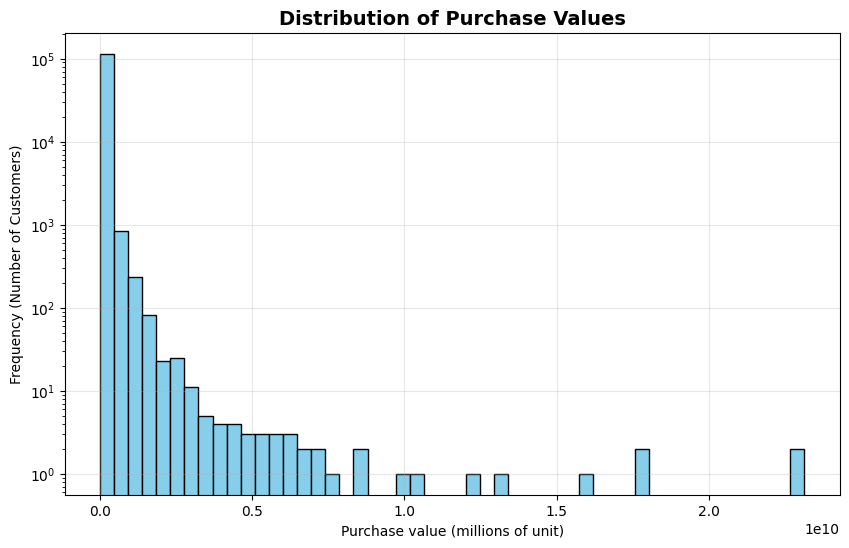

Distribution Analysis:

Total customers: 116023
Zero purchases: 92038 (79.3%)
Non-zero purchases: 23985 (20.7%)


In [8]:
# Plot 1: Distribution of Purchase Values
plt.figure(figsize=(10, 6))
plt.hist(train['purchaseValue'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Purchase Values', fontsize=14, fontweight='bold')
plt.xlabel('Purchase value (millions of unit)')
plt.ylabel('Frequency (Number of Customers)')
plt.grid(True, alpha=0.3)
plt.yscale('log') #log scale used
plt.show()

# Print key statistics
print("Distribution Analysis:\n")
print(f"Total customers: {len(train)}")
print(f"Zero purchases: {(train['purchaseValue'] == 0).sum()} ({(train['purchaseValue'] == 0).mean()*100:.1f}%)")
print(f"Non-zero purchases: {(train['purchaseValue'] > 0).sum()} ({(train['purchaseValue'] > 0).mean()*100:.1f}%)")


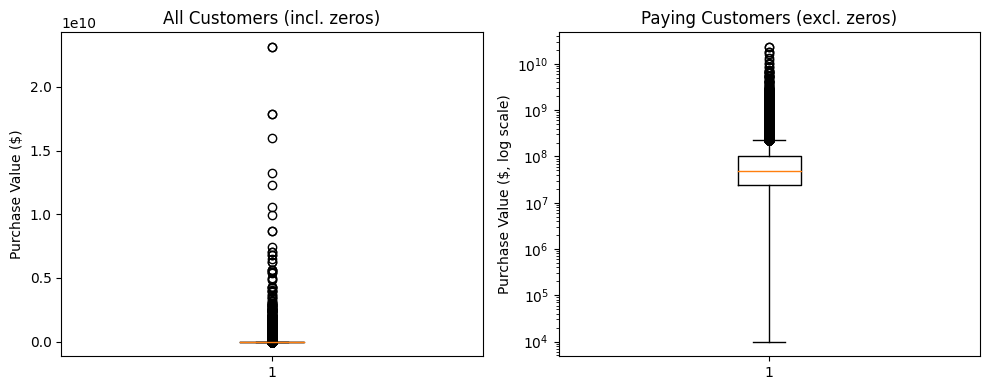

In [9]:
# Plot 2: Box Plot for Outlier Detection

non_zero = train['purchaseValue'][train['purchaseValue'] > 0]

# Box plot for full dataset
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.boxplot(train['purchaseValue'], vert=True)
plt.ylabel('Purchase Value ($)')
plt.title('All Customers (incl. zeros)')

# Box plot for paying customers only, with log scale
plt.subplot(1,2,2)
plt.boxplot(non_zero, vert=True)
plt.yscale('log')
plt.ylabel('Purchase Value ($, log scale)')
plt.title('Paying Customers (excl. zeros)')

plt.tight_layout()
plt.show()


In [10]:
print("-"*12,"Box Plot Analysis:","-"*12)
print("=" * 50)

# Full dataset analysis (including zeros)
q1_full = train['purchaseValue'].quantile(0.25)
q3_full = train['purchaseValue'].quantile(0.75)
median_full = train['purchaseValue'].quantile(0.50)
iqr_full = q3_full - q1_full

print("FULL DATASET (including zeros):\n")
print(f" - Q1 (25th percentile): ${q1_full:.2f}")
print(f" - Median (50th percentile): ${median_full:.2f}")
print(f" - Q3 (75th percentile): ${q3_full:.2f}")
print(f" - IQR: ${iqr_full:.2f}")

print(" IQR = 0 because more than 75% of customers spent $0")


------------ Box Plot Analysis: ------------
FULL DATASET (including zeros):

 - Q1 (25th percentile): $0.00
 - Median (50th percentile): $0.00
 - Q3 (75th percentile): $0.00
 - IQR: $0.00
 IQR = 0 because more than 75% of customers spent $0


In [11]:
# Analysis for Paying Customers Only
q1_buyers = non_zero.quantile(0.25)
q3_buyers = non_zero.quantile(0.75)
median_buyers = non_zero.quantile(0.50)
iqr_buyers = q3_buyers - q1_buyers

# Calculating outlier bounds for paying customers
lower_bound_buyers = q1_buyers - 1.5 * iqr_buyers
upper_bound_buyers = q3_buyers + 1.5 * iqr_buyers

# Find outliers among paying customers
buyer_outliers = non_zero[(non_zero < lower_bound_buyers) | (non_zero > upper_bound_buyers)]
print("PAYING CUSTOMERS ONLY (20.7% of customers):\n")
print(f"  - Minimum paid purchase: ${non_zero.min()}")
print(f"  - Q1 (25th percentile): ${q1_buyers:,.2f}")
print(f"  - Median (50th percentile): ${median_buyers:,.2f}")
print(f"  - Q3 (75th percentile): ${q3_buyers:,.2f}")
print(f"  - IQR: ${iqr_buyers:,.2f}")
print(f"  - Lower outlier threshold: ${lower_bound_buyers:,.2f}")
print(f"  - Upper outlier threshold: ${upper_bound_buyers:,.2f}")

# Revenue analysis
total_revenue = train['purchaseValue'].sum()
outlier_revenue = buyer_outliers.sum()

print(f"\n > Revenue Impact:")
print(f"  - Total revenue: ${total_revenue:,.2f}")
print(f"  - Revenue from outliers: ${outlier_revenue:,.2f}")
print(f"  - Outliers contribute {outlier_revenue/total_revenue*100:.1f}% of total revenue")

# spending categories
print(f"\n > Spending Categories (paying customers):")

# spending ranges
small_spenders = non_zero[non_zero <= q1_buyers]
medium_spenders = non_zero[(non_zero > q1_buyers) & 
                                    (non_zero <= q3_buyers)]
large_spenders = non_zero[(non_zero > q3_buyers) & 
                                   (non_zero <= upper_bound_buyers)]
outlier_spenders = non_zero[non_zero > upper_bound_buyers]

print(f"  - Small spenders (<= ${q1_buyers:,.0f}): {len(small_spenders)} customers")
print(f"  - Medium spenders (${q1_buyers:,.0f} - ${q3_buyers:,.0f}): {len(medium_spenders)} customers")
print(f"  - Large spenders (${q3_buyers:,.0f} - ${upper_bound_buyers:,.0f}): {len(large_spenders)} customers")
print(f"  - VIP spenders (> ${upper_bound_buyers:,.0f}): {len(outlier_spenders)} customers")


PAYING CUSTOMERS ONLY (20.7% of customers):

  - Minimum paid purchase: $10000.0
  - Q1 (25th percentile): $23,990,000.00
  - Median (50th percentile): $47,700,000.00
  - Q3 (75th percentile): $103,600,000.00
  - IQR: $79,610,000.00
  - Lower outlier threshold: $-95,425,000.00
  - Upper outlier threshold: $223,015,000.00

 > Revenue Impact:
  - Total revenue: $3,082,026,860,000.00
  - Revenue from outliers: $1,889,441,890,000.00
  - Outliers contribute 61.3% of total revenue

 > Spending Categories (paying customers):
  - Small spenders (<= $23,990,000): 6066 customers
  - Medium spenders ($23,990,000 - $103,600,000): 11923 customers
  - Large spenders ($103,600,000 - $223,015,000): 3151 customers
  - VIP spenders (> $223,015,000): 2845 customers


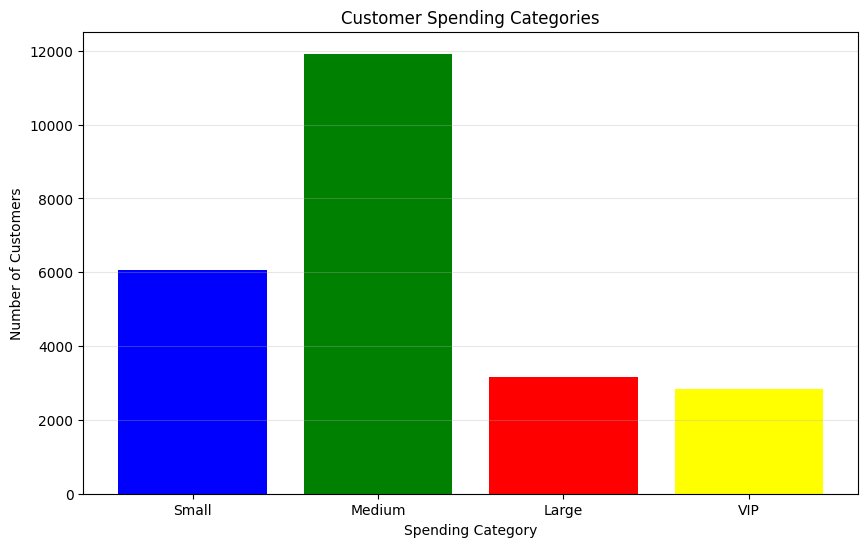

In [12]:
# Bar graph for spending categories
categories = ['Small', 'Medium', 'Large', 'VIP']
customer_counts = [6066, 11923, 3151, 2845]

# Create bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, customer_counts, 
               color=['blue', 'green', 'red', 'yellow'])

plt.title('Customer Spending Categories')
plt.xlabel('Spending Category')
plt.ylabel('Number of Customers')
plt.grid(True, alpha=0.3, axis='y')

plt.show()


## 3.3 Missing Data Analysis

In [13]:
# Missing data analysis
print("=" * 60)
print("-"*12,"MISSING DATA ANALYSIS","-"*12)
print("=" * 60)

# Check for 'not available in demo dataset' values
zero_value_cols = []
partial_missing_cols = []

print("-"*12,"Partially Filled:","-"*12)
for col in train.columns:
    if train[col].dtype == 'object':  # Only check text columns
        not_available = (train[col] == 'not available in demo dataset').sum()
        if not_available == train.shape[0]:  # All values are 'not available'
            zero_value_cols.append(col)
        elif not_available > 0:  # Some values are 'not available'
            partial_missing_cols.append((col, not_available))
            print(f"{col}: {not_available} 'not available in dataset' values ({not_available/train.shape[0]*100:.1f}%)")

print(f"\n Completely empty columns ({len(zero_value_cols)}):\n {zero_value_cols}")



------------ MISSING DATA ANALYSIS ------------
------------ Partially Filled: ------------
geoNetwork.region: 60138 'not available in dataset' values (51.8%)
geoNetwork.city: 60138 'not available in dataset' values (51.8%)
geoNetwork.metro: 60138 'not available in dataset' values (51.8%)

 Completely empty columns (13):
 ['device.screenResolution', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName', 'device.operatingSystemVersion', 'device.flashVersion', 'geoNetwork.networkLocation', 'browserMajor', 'device.browserSize', 'device.mobileDeviceModel', 'device.language', 'device.browserVersion', 'device.screenColors']



 Missing Values % Column-wise:
 trafficSource.adContent: 97.4%
 trafficSource.adwordsClickInfo.isVideoAd: 96.3%
 trafficSource.adwordsClickInfo.page: 96.3%
 trafficSource.adwordsClickInfo.adNetworkType: 96.3%
 trafficSource.adwordsClickInfo.slot: 96.3%
 trafficSource.referralPath: 63.2%
 trafficSource.isTrueDirect: 63.0%
 trafficSource.keyword: 61.9%
 totals.bounces: 59.4%
 new_visits: 30.6%
 pageViews: 0.0%


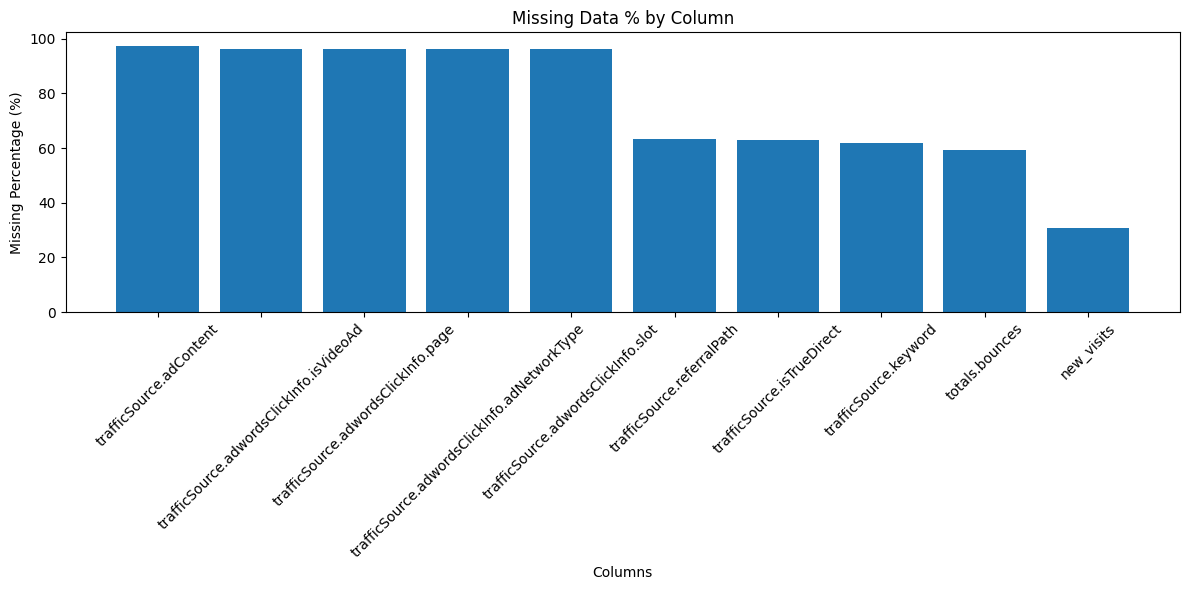

In [14]:
# Null/missing values
missing_percent = (train.isnull().sum() / len(train) * 100).sort_values(ascending=False)
missing_columns = missing_percent[missing_percent > 0]

print("\n Missing Values % Column-wise:")
print("=" * 40)

if len(missing_columns) > 0:
    for column, percentage in missing_columns.items():
        print(f" {column}: {percentage:.1f}%")
    
    # Visualize missing data
    plt.figure(figsize=(12, 6))
    top_missing = missing_columns.head(10)
    plt.bar(range(len(top_missing)), top_missing.values)
    plt.title('Missing Data % by Column')
    plt.xlabel('Columns')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(range(len(top_missing)), top_missing.index, rotation=45)
    plt.tight_layout()
    plt.show()

## 3.4 Visualizing Features

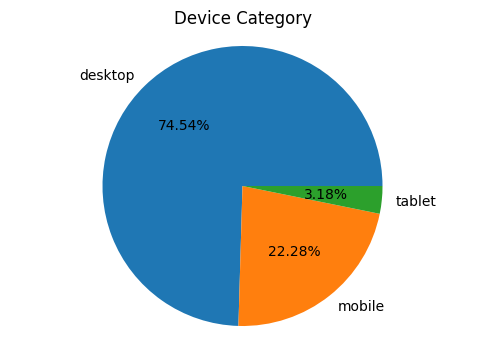

In [15]:
import matplotlib.pyplot as plt

group = train.groupby('deviceType').size().rename('Count').reset_index()

# pie chart Device category
plt.figure(figsize=(6, 4))
plt.pie(group['Count'], 
         labels=group['deviceType'], 
         autopct='%1.2f%%')

plt.title('Device Category')
plt.axis('equal')
plt.show()

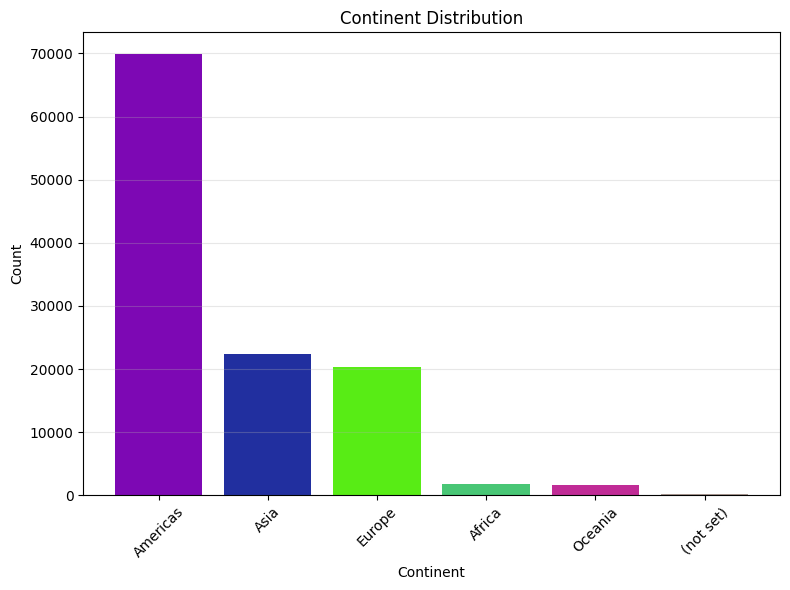

In [16]:
continents = train['geoNetwork.continent'].value_counts()
num_bars = len(continents)
random_colors = np.random.rand(num_bars, 3) 

# bar chart for Continent Distribution 
plt.figure(figsize=(8, 6))
plt.bar(continents.index, continents.values,color=random_colors)

plt.title('Continent Distribution')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()



# 4. Data Cleaning

In [17]:
# Filling the missing values and Also Changing "(not set)" and "not available in dataset" columns to Nan.

#Defined Function
def fill_na(df):   
    df['pageViews'] = df['pageViews'].fillna(1)
    df['new_visits'] = df['new_visits'].fillna(0)
    df['totals.bounces'] = df['totals.bounces'].fillna(0)
    
    df['trafficSource.isTrueDirect'] = df['trafficSource.isTrueDirect'].fillna(False)
    
    # filling all 'not set' and 'not available in demo dataset' 
    df.loc[(df['geoNetwork.city'] == "(not set)") | 
    (df['geoNetwork.city'] == "not available in demo dataset"),'geoNetwork.city'] = np.nan
    
    df['geoNetwork.city'] = df['geoNetwork.city'].fillna("NaN")

    df.loc[(df['geoNetwork.metro'] == "(not set)") | 
    (df['geoNetwork.metro'] == "not available in demo dataset"),'geoNetwork.metro'] = np.nan
    
    df['geoNetwork.metro'] = df['geoNetwork.metro'].fillna("NaN")

    df.loc[(df['geoNetwork.region'] == "(not set)") | 
    (df['geoNetwork.region'] == "not available in demo dataset"),'geoNetwork.region'] = np.nan
    
    df['geoNetwork.region'] = df['geoNetwork.region'].fillna("NaN")

    df.loc[df['geoNetwork.continent'] == "(not set)", 'geoNetwork.continent'] = np.nan
    
    df['geoNetwork.continent'] = df['geoNetwork.continent'].fillna("NaN")

    return df

train = fill_na(train)
test = fill_na(test)

## 4.1 Dropping all the defined empty columns 

In [18]:
#zero_value_cols defined earlier
print(zero_value_cols)

['device.screenResolution', 'device.mobileDeviceBranding', 'device.mobileInputSelector', 'device.mobileDeviceMarketingName', 'device.operatingSystemVersion', 'device.flashVersion', 'geoNetwork.networkLocation', 'browserMajor', 'device.browserSize', 'device.mobileDeviceModel', 'device.language', 'device.browserVersion', 'device.screenColors']


In [19]:
# Zero values are 100% empty and No value are more than 60% 
No_value = ['trafficSource.adContent',
         'trafficSource.keyword',
         'trafficSource.referralPath',
         'trafficSource.adwordsClickInfo.slot',
         'trafficSource.adwordsClickInfo.isVideoAd',
         'trafficSource.adwordsClickInfo.adNetworkType',
         'trafficSource.adwordsClickInfo.page'
        ]
train.drop(columns=(No_value + zero_value_cols),inplace =True)
test.drop(columns=(No_value + zero_value_cols),inplace =True)

## 4.2 Dropping constanst columns


In [20]:
constant_cols = [col for col in train.columns if train[col].nunique() == 1]
print(f'Columns : {constant_cols}')


train.drop(constant_cols, axis=1, inplace=True)
test.drop(constant_cols, axis=1, inplace=True)

Columns : ['screenSize', 'totals.visits', 'socialEngagementType', 'locationZone']


## 4.3 Dropping High cardinality Columns

In [21]:
# Finding High cardinality features

# Calculate the number of unique values for each categorical column
cardinality = train.nunique()

print("Cardinality of each column:")
print(cardinality.sort_values(ascending=False))


Cardinality of each column:
sessionStart                  107388
sessionId                     107379
userId                        100499
purchaseValue                   6766
geoNetwork.city                  694
date                             638
geoNetwork.region                387
sessionNumber                    230
totalHits                        225
locationCountry                  193
pageViews                        175
trafficSource                    161
geoNetwork.metro                 103
browser                           34
trafficSource.campaign            28
geoNetwork.subContinent           23
os                                18
userChannel                        8
trafficSource.medium               7
geoNetwork.continent               6
geoCluster                         5
geoNetwork.networkDomain           3
deviceType                         3
device.isMobile                    2
trafficSource.isTrueDirect         2
totals.bounces                     2
gclIdPrese

In [22]:
#finding correlation between sesionStart and sessionId before dropping:

correlation = train['sessionStart'].corr(train['sessionId'])
print(f"Correlation: {correlation:.4f}")


Correlation: 1.0000


In [23]:
#finding correlation between sesionStart and date before dropping one of them:

correlation = train['sessionStart'].corr(train['date'])
print(f"sessionStart vs date correlation: {correlation:.6f}")

sessionStart vs date correlation: 0.912567


In [24]:
#dropping sessionId and userId (identifier columns):

train.drop(columns=['sessionId', 'userId'], inplace=True)
test.drop(columns=['sessionId', 'userId'], inplace=True)


In [25]:
train.info()
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116023 entries, 0 to 116022
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   trafficSource.isTrueDirect  116023 non-null  bool   
 1   purchaseValue               116023 non-null  float64
 2   browser                     116023 non-null  object 
 3   geoCluster                  116023 non-null  object 
 4   trafficSource.campaign      116023 non-null  object 
 5   geoNetwork.networkDomain    116023 non-null  object 
 6   gclIdPresent                116023 non-null  int64  
 7   sessionNumber               116023 non-null  int64  
 8   geoNetwork.region           116023 non-null  object 
 9   trafficSource               116023 non-null  object 
 10  os                          116023 non-null  object 
 11  geoNetwork.subContinent     116023 non-null  object 
 12  trafficSource.medium        116023 non-null  object 
 13  locationCountr

## Correlation Heatmap

- Shows how Numerical features are correalted with PurchaseValue and with each other 

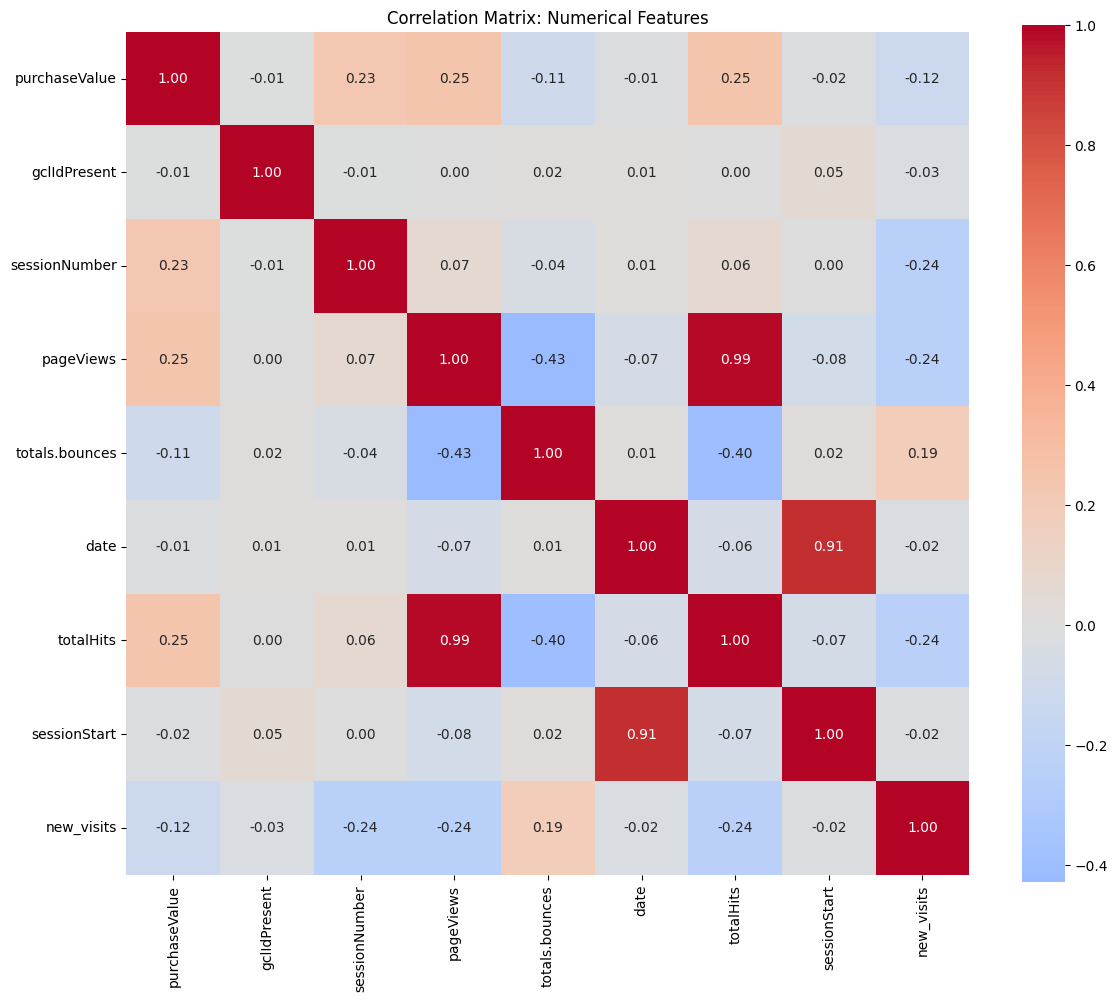

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# selecting numerical columns
numeric_cols = train.select_dtypes(include=[np.number]).columns
corr_matrix = train[numeric_cols].corr()

# correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, 
           annot=True, 
           cmap='coolwarm', 
           center=0, 
           square=True, 
           fmt='.2f')

plt.title('Correlation Matrix: Numerical Features')
plt.tight_layout()
plt.show()


# 5.  Data Preprocessing & Feature Engineering

## 5.1 Extracting Date & time features

In [27]:
# Feature Engineering sessionStart column
def date_time_features(df):
    # Converting to datetime
    df['sessionStart_dt'] = pd.to_datetime(df['sessionStart'], unit='s')  #sessionStart was represented in Unix timestamp
    
    df['week_day'] = df['sessionStart_dt'].dt.dayofweek
    df['month'] = df['sessionStart_dt'].dt.month
    df['hour'] = df['sessionStart_dt'].dt.hour
    df['is_weekend'] = (df['week_day'] >= 5).astype(int)
    
    # Time periods
    df['period'] = pd.cut(df['hour'],bins=[0, 6, 12, 18, 24], 
                              labels=['Night', 'Morning', 'Afternoon', 'Evening'])
    
    # Converting categorical to numerical 
    df['day_period'] = df['period'].cat.codes
    
    # Droping intermediate columns and Date
    df.drop(columns=['sessionStart_dt', 'period','date'], inplace=True)
    
    return df

train = date_time_features(train)
test = date_time_features(test)

## 5.2 Splitting the Dataset

In [28]:
X = train.drop('purchaseValue', axis=1)
y = train['purchaseValue']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Target training shape: {y_train.shape}")
print(f"Target validation shape: {y_val.shape}")

Training set shape: (92818, 29)
Validation set shape: (23205, 29)
Target training shape: (92818,)
Target validation shape: (23205,)


In [29]:

# numerical and categorical columns
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("Numerical columns:", num_cols)
print("\nCategorical columns:", cat_cols)

Numerical columns: ['gclIdPresent', 'sessionNumber', 'pageViews', 'totals.bounces', 'totalHits', 'sessionStart', 'new_visits', 'week_day', 'month', 'hour', 'is_weekend', 'day_period']

Categorical columns: ['browser', 'geoCluster', 'trafficSource.campaign', 'geoNetwork.networkDomain', 'geoNetwork.region', 'trafficSource', 'os', 'geoNetwork.subContinent', 'trafficSource.medium', 'locationCountry', 'geoNetwork.city', 'geoNetwork.metro', 'deviceType', 'userChannel', 'geoNetwork.continent']


# 6. Model Training

## 6.1 XGBoost

In [30]:
# def Xgbmodel():
#     from sklearn.pipeline import Pipeline
#     from sklearn.impute import SimpleImputer
#     from sklearn.preprocessing import StandardScaler, OrdinalEncoder
#     from sklearn.compose import ColumnTransformer
#     import xgboost as xgb
    
#     #num_features = ['sessionNumber','pageViews', 'totalHits', 'sessionStart','day_period', 'gclIdPresent']
    
#     sel_num = ['sessionNumber', 'pageViews', 'totalHits' ,'sessionStart','new_visits','month','hour'] 
    
#     cat_features = ['browser','userChannel','geoNetwork.continent','geoNetwork.metro',
#                    'geoNetwork.city','locationCountry', 'geoNetwork.region','geoNetwork.subContinent']

#     #sel_cat =  ['browser','geoCluster','trafficSource','os','deviceType','userChannel',]


#     # Creating transformers 
#     num_pipeline = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler())
#     ])
    
#     cat_pipeline = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OrdinalEncoder(
#             handle_unknown='use_encoded_value', 
#             unknown_value=-1
#         ))
#     ])
    
#     # Preprocessor
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', num_pipeline, sel_num),
#             ('cat', cat_pipeline, cat_features)
#         ],
#         remainder='drop'
#     )
    
#     # Complete pipeline
#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('regressor', xgb.XGBRegressor(
#             learning_rate=0.15,  # Using eta value
#             max_depth=8,
#             min_child_weight=100,
#             gamma=5,
#             subsample=1,
#             colsample_bytree=0.95,
#             colsample_bylevel=0.35,
#             reg_alpha=25,
#             reg_lambda=25,
#             n_jobs=-1,
#             verbosity=0,
#             random_state=42,
#             n_estimators=100
#         ))
#     ])
    
#     return pipeline


# XGB = Xgbmodel()
# XGB.fit(X_train, y_train)


In [31]:
# #Checking XGboost Model performance

# # Predict on training set
# y_train_pred = XGB.predict(X_train)
# r2_train = r2_score(y_train, y_train_pred)

# # Predict on validation set
# y_val_pred = XGB.predict(X_val)
# r2_val = r2_score(y_val, y_val_pred)

# # Print both
# print(f"Training R² score: {r2_train:.4f}")
# print(f"Validation R² score: {r2_val:.4f}")

In [32]:
# import matplotlib.pyplot as plt


# regressor = XGB.named_steps['regressor']
# preprocessor = XGB.named_steps['preprocessor']

# importances = regressor.feature_importances_

# feature_names = preprocessor.get_feature_names_out()

# feature_importance_series = pd.Series(importances, index=feature_names)

# sorted_importances = feature_importance_series.sort_values(ascending=True)

# plt.figure(figsize=(12, 10))
# sorted_importances.plot(kind='barh')
# plt.title('XGBoost Feature Importance from Pipeline')
# plt.xlabel('Importance Score')
# plt.ylabel('Features')
# plt.show()

## 6.2 RandomForestRegressor

In [33]:
# def RFmodel():
#     from sklearn.pipeline import Pipeline
#     from sklearn.impute import SimpleImputer
#     from sklearn.preprocessing import StandardScaler, OrdinalEncoder
#     from sklearn.compose import ColumnTransformer
#     from sklearn.ensemble import RandomForestRegressor as RF
    
#     num_features = ['sessionNumber','pageViews', 'totalHits', 'sessionStart',
#                    'day_period','hour', 'week_day']
    
#     cat_features = ['userChannel', 'geoNetwork.continent', 'geoNetwork.metro',
#                    'geoNetwork.city', 'locationCountry', 'geoNetwork.region',
#                    'geoNetwork.subContinent']

#     # Numerical preprocessing pipeline
#     num_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler())
#     ])

#     # Categorical Preprocessing pipeline
#     cat_transformer = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OrdinalEncoder(
#             handle_unknown='use_encoded_value', 
#             unknown_value=-1
#         ))
#     ])
    
#     # Column Transformer 
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', num_transformer, num_features),
#             ('cat',cat_transformer, cat_features)
#         ],
#         remainder='drop'
#     )
    
#     pipeline = Pipeline(steps=[
#         ('preprocessor', preprocessor),
#         ('regressor', RF(
#             n_estimators=250,
#             max_depth=25,
#             min_samples_split=8,
#             min_samples_leaf=4,
#             max_features=0.2,
#             random_state=60,
#             n_jobs=-1  # Use all available cores
#         ))
#     ])
    
#     return pipeline


# RF_model = RFmodel()
# RF_model.fit(X_train, y_train)


In [34]:
# #Checking ExtraTreesRegressor Model performance

# # Predict on training set
# y_train_pred = RF_model.predict(X_train)
# r2_train = r2_score(y_train, y_train_pred)

# # Predict on validation set
# y_val_pred = RF_model.predict(X_val)
# r2_val = r2_score(y_val, y_val_pred)

# # Print both
# print(f"Training R² score: {r2_train:.4f}")
# print(f"Validation R² score: {r2_val:.4f}")


## 6.3 ExtraTreesRegressor

In [35]:
def ETRmodel():
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.impute import KNNImputer
    from sklearn.preprocessing import StandardScaler, OrdinalEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.ensemble import ExtraTreesRegressor as ETR
    
    # Feature definitions
    num_features = ['sessionNumber', 'pageViews', 'totalHits', 'sessionStart',
                    'week_day', 'month', 'hour']

    # sel_num = ['sessionNumber', 'pageViews', 'totalHits' ,'sessionStart','new_visits','month','hour'] 
    # new_num = ['sessionNumber','pageViews','date', 'totalHits', 'sessionStart',
    #        'gclIdPresent','totals.visits']

    
#     cat_features = ['browser','userChannel','geoNetwork.continent','geoNetwork.metro',
#                    'geoNetwork.city','locationCountry', 'geoNetwork.region','geoNetwork.subContinent']

#     #sel_cat =  ['browser','geoCluster','trafficSource','os','deviceType','userChannel',]
    
    # Numerical preprocessing pipeline
    num_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=10)),
        ('scaler', StandardScaler())
    ])
    
    # Column Transformer 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_features),
        ],
        remainder='drop'
    )
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', ETR(
            n_estimators=260,
            max_depth=30,
            max_features=0.2,
            random_state=60,
            min_samples_split=3,
            n_jobs=-1
        ))
    ])
    
    return pipeline


ETR_model = ETRmodel()
ETR_model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer(n_neighbors=10)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['sessionNumber', 'pageViews',
                                                   'totalHits', 'sessionStart',
                                                   'week_day', 'month',
                                                   'hour'])])),
                ('regressor',
                 ExtraTreesRegressor(max_depth=30, max_features=0.2,
                                     min_samples_split=3, n_estimators=260,
                                     n_jobs=-1, random_state=60))])

In [36]:
#Checking ExtraTreesRegressor Model performance

# Predict on training set
y_train_pred = ETR_model.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)

# Predict on validation set
y_val_pred = ETR_model.predict(X_val)
r2_val = r2_score(y_val, y_val_pred)

# Print both
print(f"Training R² score: {r2_train:.4f}")
print(f"Validation R² score: {r2_val:.4f}")


Training R² score: 0.9816
Validation R² score: 0.4384


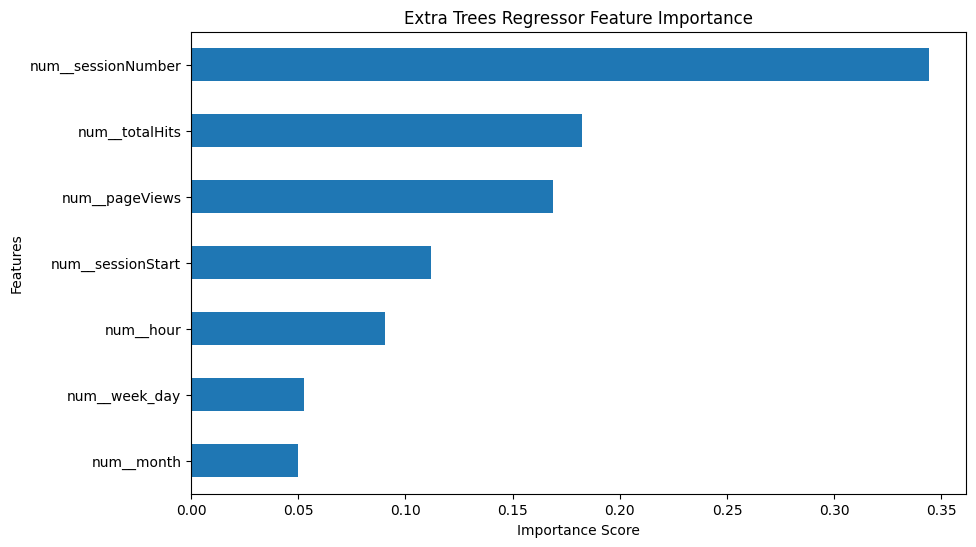

In [37]:
#Feature Importance for ExtraTreesRegressor

regressor = ETR_model.named_steps['regressor']
preprocessor = ETR_model.named_steps['preprocessor']

importances = regressor.feature_importances_

feature_names = preprocessor.get_feature_names_out()

feature_importance_series = pd.Series(importances, index=feature_names)

sorted_importances = feature_importance_series.sort_values(ascending=True)

plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh')
plt.title('Extra Trees Regressor Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

## 6.4 Model Comparison and Analysis 

Based on the results, **ExtraTreesRegressor (ETR)** performed best among the three models:

| Model | Training R2 | Validation R2 | Generalization Gap |
|-------|-------------|---------------|---------------------|
| **ETR** | 0.9838 | **0.4135** | 0.5703 |
| RF    | 0.6139 | 0.2043 | 0.4096 |
| XGB   | 0.8859 | 0.1067 | 0.7792 |

---

### ExtraTreesRegressor got:

- **Best Validation Performance**: Achieved the highest R2 (0.4135) on unseen data.
- **Better Generalization**: While it still overfits, the generalization gap is more manageable than XGBoost.
- **Randomization Benefits**: The extreme randomization in ExtraTrees helps capture complex patterns without memorizing noise.

---

### XGBoost Performed Poorly:

- **Severe Overfitting**: Massive gap between training (0.8859) and validation (0.1067) R2 score can be seen.



# 7. Final Submission

In [38]:
# # Xgboost
# # fitting on the whole dataset now
# XGB.fit(X, y)
# y_pred = XGB.predict(test)

In [39]:
# # RandomForestRegressor

# RF_model.fit(X, y)
# y_pred = RF_model.predict(test)

In [40]:
# ExtraTreesRegressor
ETR_model.fit(X, y)
y_pred = ETR_model.predict(test)

In [41]:
#creating final submission fie:
submission = pd.DataFrame({"id": np.arange(len(y_pred)),"purchaseValue": y_pred})
submission.to_csv('/kaggle/working/submission.csv', index=False)